In [1]:
from IPython.display import Image

## Introduction


- RNN, LSTM, GRE 등등은 SOTA를 달성했지만 변환 문제가 있다.
- Encode-Decoder 아키텍쳐와 Recurrent 모델의 바운더리를 넓히려는 많은 노력들이 시도되옴
- RNN의 순차적인 특성은 훈련 예제 내에서 병렬 처리를 방해하기 때문에 메모리 제약이 생겨 시퀀스 길이에서 매우 중요해짐.
- 많이 개선되었지만 아직도 멀었다.
- 그래서 어텐션 매커니즘이 핵심적인 요소로 주목 받음. 입력 또는 출력 시퀀스에서의 거리에 관계없이 종속성을 모델링 할 수 있기 때문
- RNN을 배제한 어텐션 메커니즘에 완전히 의존하여 입력과 출력 사이의 전역 의존성을 추출하는 모델 아키텍처인 Transformer를 제안함.
- Transformer는 뛰어난 병렬 처리를 가능하게 하고 번역 퀄리티의 SOTA를 달성했음



## Background

- 시퀀셜 계산량을 줄이려는 목표는 CNN의 베이직 구성 요소로서 만들게 됨
- 이러한 모델들은 두 임의의 입력 또는 출력 위치 사이의 신호를 연결하기 위해 필요한 연산의 수가 위치 사이의 거리에 따라 선형적으로 또는 로그로 증가함. 이러한 점이 의존 관계를 학습하는데 어렵게 한다. 
- 트랜스포머에서는 이를 상수 연산량으로 감소시키지만, 해상도의 감소를 가져온다. 이는 멀티 헤드 어텐션으로 대응.
- 셀프 어텐션(내적 어텐션으로 불리는)은 싱글 시퀀스의 다른 포지션을 연결하는 어텐션 메커니즘이다. 시컨스의 표현을 계산하기 위해.
- 셀프 어텐션은 다양한 곳에서 훌륭히 사용되어왔다.
- 엔드 투 엔드 네트워크는 Recurrent 어텐션 메커니즘을 베이스로 둔다. 순차적 대신. 그리고 심플 언어 QA와 언어 모델 과제에서 괜찮은 성능을 보인다.
- 트랜스포머는 전적으로 셀프 어텐션에만 기반한 첫 전이 모델이다. 입력 출력 표현을 계산하기 위해. RNN, CNN을 사용하지 않고

## Model Architecture

- 가장 경쟁력 있는 전이 모델은 인코더-디코더 구조
- 인코더는 기호 표현의 입력 시퀀스 (x1, ..., xn)를 연속적인 표현의 시퀀스인 z = (z1, ..., zn)로 매핑
- 디코더는 주어진 z를 바탕으로, 디코더는 한 번에 한 요소씩 기호의 출력 시퀀스 (y1, ..., ym)를 생성
- 각 스텝마다 모델은 자동 회귀하고, 이전에 생성된 기호를 추가 입력으로 소비한다. 다음을 생성할 때 
- 트랜스포머의 아키텍쳐는 아래와 같다.
- 중첩된 셀프 어텐션과 point-wise를 이용한다. 인코더와 디코더 모두에 대해 완전히 연결된 계층으로. 이는 각각 아래의 왼쪽 및 오른쪽 절반에서 보여집니다.

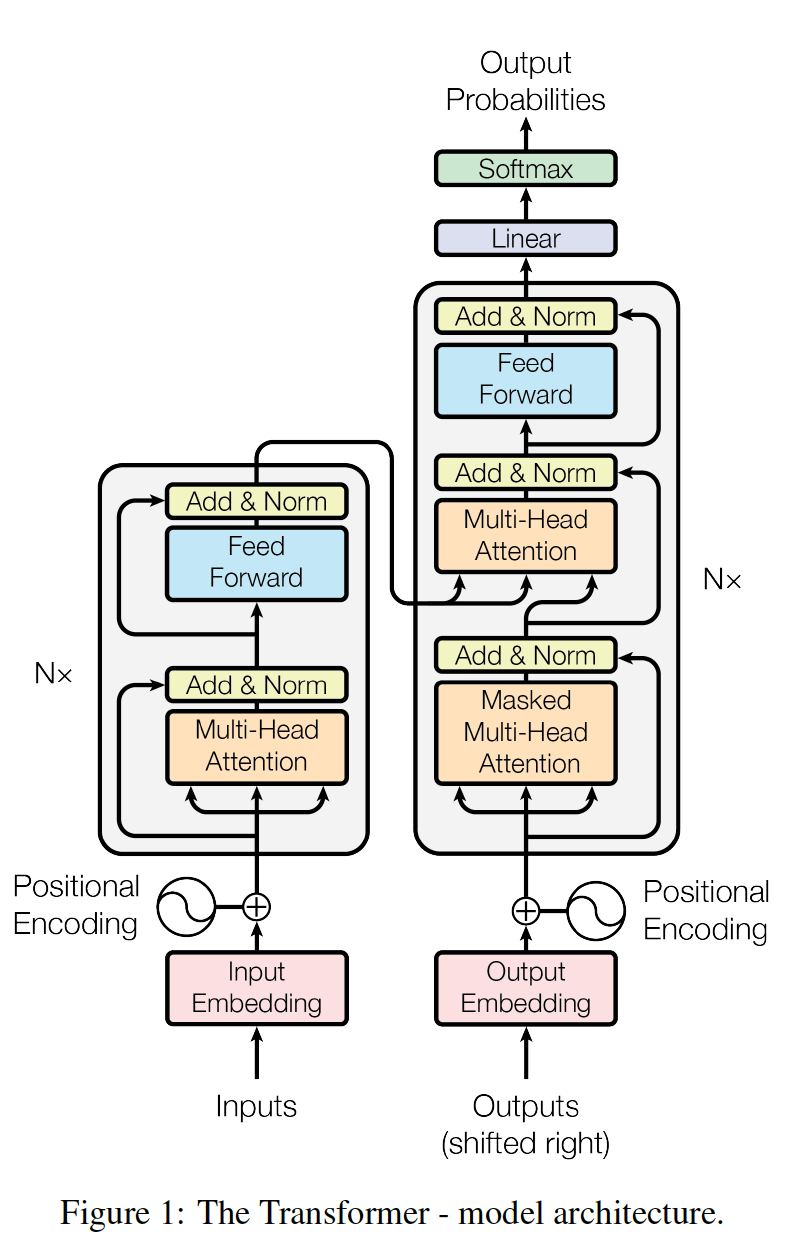

In [2]:
Image("img/architecture.png")

## Encoder and Decoder Stacks

**Encoder**
- 인코더는 6개의 동일한 레이어로 구성
- 각각의 레이어는 2개의 서브 레이어로 구성.
- 하나는 멀티 헤드 셀프 어텐션, 다른 하나는 포지션별로 fc feed-forward 간단한 네트워크(위 그림의 왼쪽)
- 2개의 서브 레이어를 각각 둘러싼 잔차 연결(Residual connection; 쉽게 말해 이전 레이어의 결과를 다시 활용하는 것. ResNet에서 제시)을 활용한다. 계층 정규화가 뒤따르는.
- 각각의 서브 레이어의 출력은 LayerNorm(x + Sublayer(x))와 같다.
- Sublayer(x)는 서브 레이어 자체에 의해 실행된 함수
- 이러한 잔차 연결 활용을 위해, 모든 서브 레이어는 (임베딩도 포함해서) 512차원의 결과물을 생성.

**Decoder**
- 디코더도 6개의 동일한 레이어로 구성
- 인코더 레이어 2개의 서브 레이어에 하나가 추가됨
- 세번째 서브 레이어는 멀티 헤드 어탠션을 수행한다. 인코드 스택의 출력을 입력으로 받아서.
- 인코더와 유사하게 각각의 서브 레이어에 대해 잔차 연결을 하고 레이어 정규화를 진행한다.
- 그리고 디코더의 셀프 어텐션 서브 레이어를 다음과 같이 수정. 디코더 스택의 포지션이 이후 위치에 주의를 기울이지 않도록 방지하도록(어떻게???)
- 이 마스킹은 출력 임베딩이 특정 포지션에 오프셋(이동, 밀림)되어 있다는 사실과 결합하여, 위치 i에 대한 예측이 i보다 작은 위치에서의 알려진 출력에만 의존할 수 있게 보장.


## Attention

- 어텐션 함수는 쿼리와 키-값 쌍의 출력을 매핑하는 것으로 표현. 쿼리, 키, 값 그리고 출력은 모두 벡터.
- 출력은 weighted-sum으로 값들을 계산. 각각의 값에 부여되는 가중치는 쿼리와 해당 키의 호환성 함수에 의해 계산

**Scaled Dot-Product Attention**
- SDP의 입력은 쿼리들과 d<sub>k</sub> 차원의 키들과 d<sub>v</sub> 차원의 값들로 구성.
- 쿼리와 모든 키를 내적하고, 각각을 &radic;d<sub>k</sub>로 나눈후 소프트맥스 함수를 적용한다. 값에 가중치를 부여하기 위해
- 실제로, 쿼리들의 집합에 대해 어텐션 함수를 동시에 계산하며, 이들은 행렬 Q에 함께 패키징됨
- 키와 값도 마찬가지로 행렬 K와 V에 함께 패키징됨. 
- 출력의 행렬을 다음과 같이 계산:
$$ \text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

- 가장 많이 활용되는 어텐션 함수는 additvie 어텐션과 내적 어텐션.
- 내적 어텐션은 본 논문의 알고리즘과 스케일링(1/√d<sub>k</sub>) 하는 부분을 제외하곤 동일하다.
- additive 어텐션은 싱글 히든 레이어를 갖는 feed-forward 네트워크를 활용하여 호환성 함수(연관성을 체크하는)를 계산한다.
- 두 개의 복잡도가 거의 유사하지만, 내적 어텐션은 더 빠르고 공간 효율적이다. 굉장히 최적화된 행렬 곱 코드를 활용하여 구현될 수 있기 때문.
- 작은 d<sub>k</sub> 차원의 값에서는 두 매커니즘은 유사하게 동작하지만, 큰 d<sub>k</sub> 차원에서는 스케일링 없는 내적 어텐션을 ad 에텐션이 능가한다.
- 큰 차원의 d<sub>k</sub>은 내적 곱의 값을 크게 만들고 이는 소프트맥스 함수를 극도로 작은 기울기로 만든다.
    - Softmax 함수는 벡터의 각 요소를 0과 1 사이의 확률 값으로 변환하는 역할. 그러나 입력 벡터 중 특정 값이 매우 클 경우, softmax의 출력값 중 하나가 1에 가깝고 나머지는 거의 0에 가까워집니다. 이러한 현상을 "softmax 함수가 뾰족해진다"라고 표현. 이런 상황에서는 해당 벡터 요소의 소프트맥스 함수의 기울기(미분값)가 거의 0에 가까워집니다. 이는 "기울기 소실(Vanishing Gradient)" 문제를 유발하며, 이는 신경망이 제대로 업데이트되지 않거나 학습이 느려지는 원인이 됨. 그래서, 내적의 결과가 너무 크지 않도록 스케일링하는 것이 필요하며, 이를 위해 dot product를 차원의 제곱근으로 나누는 스케일링이 사용
- 이에 대응하기 위해 스케일링을 한다.

**Multi-Head Attention**
- 단일 어텐션 함수를 사용하는 것보다 h-times 다르게 쿼리, 키, 값을 투영하는 것이 이득이다라는 것을 확인
    - 어떻게 투영한다는 것이지?
- 각각의 투영된 쿼리, 키, 값은 병렬적으로 어텐션 함수를 수행하여 d<sub>v</sub>차원의 출력을 얻는다.
- 멀티 헤드 어텐션은 모델이 서로 다른 표현 공간으로부터 다른 위치에서 정보를 기울이게 만든다.
- 싱글 어텐션 헤드에서는 평균화가 이를 억제한다.
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O $$

where 
$$ \text{head}_i = \text{Attention}(QW_{Qi}, KW_{Ki}, V W_{Vi}) $$
- 트랜스포머는 여덟 개의 병렬 어텐션 레이어를 활용하고 각각은 64?
- 각각 헤드의 감소된 차원으로 인해, 총 계산 비용은 싱글 헤드의 풀 차원과 동일하다.

**Applications of Attention in our Model**
- 멀티 헤드 어텐션은 트랜스포머에서 다음과 같이 세 가지 방법으로 사용됨
    - 인코더-디코더 어텐션에서, 쿼리는 이전 디코더 레이어에서, 그리고 메모리 키와 값은 인코더의 결과 값에서 나온다. 디코더의 모든 포지션에서 입력 시퀀스의 모든 포지션에 대해 주의를 기울일 수 있다. 이것은 전통적인 Seq2Seq 모델의 인코더-디코더 메커니즘을 따라한다.
    - 인코더는 셀프 어텐션 레이어를 가지고 있다. 셀프 어텐션 레이어의 모든 키, 값, 쿼리는 값은 장소에서 가져오며, 이 경우에는 인코더의 이전 레이어 결과 값이다. 인코더에서 각각의 포지션은 이전 인코더 레이어의 모든 포지션에 대해 주의를 기울인다.
    - 유사하게, 디코더의 셀프 어텐션 레이어는 디코더 각각의 포지션이 디코더의 해당 포지션부터 모든 포지션까지 주의를 기울인다. 디코더에서 왼쪽 방향의 정보 흐름을 방지하여 오토-레그레시브 특성을 보존하기 위해 이를 구현한다. 이 작업은 스케일드 닷-프로덕트 어텐션(scaled dot-product attention) 내부에서 수행되며, 잘못된 연결에 해당하는 소프트맥스의 입력 값들을 마스킹하여 (-∞로 설정하여) 처리

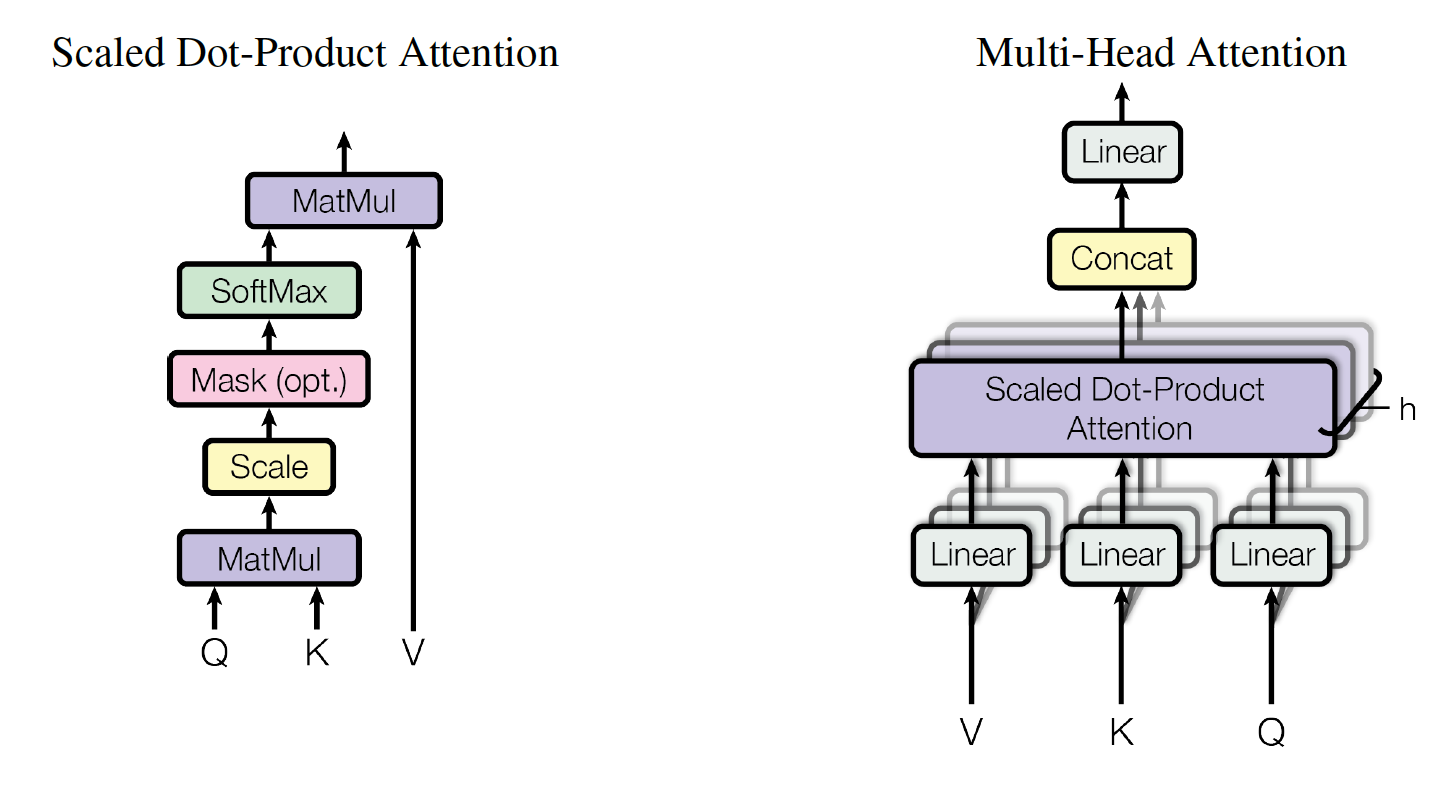

In [4]:
Image("img/attention.png")

## Position-wise Feed-Forward Networks
- 어텐션의 서브 레이어에 추가로, 각각의 인코더 디코더 레이어들은 FC Feed-forward 네트워크를 포함한다. 각각의 포지션을 독립적이고 동일하게 적용 가능케 하는. 이 네트워크는 두 개의 선형 변환 함수와 그 사이의 RELU 활성화 함수로 구성된다.

$$ \text{PPM}(x) = \text{max}(0, xW_1+b+1)W_2 + b_2 $$

- 선형 변환이 다른 포지션에서도 동일하지만, 레이어마다 다른 파라미터를 사용한다. 다른 식으로 표현하자면 이는 커널 사이즈가 1인 2개의 CNN을 의미한다. 입력과 출력의 차원은 dmodel = 512이며, 내부 레이어의 차원은 dff = 2048

## Embeddings and Softmax
- 다른 시퀀스 변이 모델과 유사하게, 학습된 임베딩을 사용한다. 입력 토큰과 출력 토큰을 dmodel 차원의 벡터로 변환하기 위해서. 
- 또한, 일반적인 학습된 선형 병환과 소프트맥스 함수를 사용한다. 디코더의 출력을 예측된 다음 토큰의 확률로 변환하기 위해서.
- 두 개의 임베딩 레이어와 pre-소프트맥스 선형 변혐 함수의 weight 행렬도 공유했다. 임베딩 레이어에서 그러한 weight를 곱한다. 

## Positional Encoding
- RNN, CNN을 활용하지 않기 때문에 모델의 시퀀스 순서를 위해 몇 가지 상대적, 절대적 시퀀스 토큰의 위치 정보를 주입해야만 했다.
- Positional encodings를 입력 레이어의 바닥에 추가했다. 인코더 디코더 스택의
- PE는 임베딩처럼 dmodel과 같은 차원을 가지고 있다. 두 가지를 합하기 위해서.
- 여기서는 사인 코사인 함수를 다른 전제와 함께 사용한다.

$$ PE_{(pos, 2i)} = sin(pos/10000)^{2i/d_{model}}) $$
$$ PE_{(pos, 2i+1)} = cos(pos/10000)^{2i/d_{model}}) $$

- pos는 포지션을 의미하고 i는 차원을 의미한다.
- 즉 각각의 포지션 인코딩 차원은 사인 곡선에 해당된다.
- 웨이브 렝스는 2파이부터 10000*2파이까지 기하적 연속 형태를 구성한다.
- 우리는 이 함수를 선택한 이유는 다음과 같은 가설을 세웠기 때문.
- 이것이 모델이 쉽게 상대적인 위치에 따라 학습할 수 있게 하기 때문.
- 고정된 오프셋 k에 대해 PE_{pos+k}를 PE_{pos}의 선형 함수로 표현할 수 있기 때문
- 또한 학습된 PE를 사용하여 실험했고 두 가지 버전은 거의 동일한 결과물을 만들어냈다.
- 우리는 사인 곡선을 버젼을 사용한다. 사인 곡선은 모델이 긴 길이의 시퀀스를 추론하도록 했기 때문이다.(학습 중 마주한 시퀀스보다 긴 시퀀스)

## Why self-Attention
- 다양한 관점에서 셀프 어텐션 레이어를 RNN과 CNN 레이어와 비교한다. 
- 하나는 각 레이어의 연산 복잡도, 다른 하나는 병렬 연산이 가능한지, 마지막은 path length
- long-range를 학습하는 것은 주요 챌린지 이다. 시퀀스 변환 테스크의
- 하나의 주요 롱 래인지 학습의 팩터는 패쓰의 길이이다. 시그널이 포워드 백워드로 네트워크에서 탐험해야 하는.
- 입력 시퀀스와 출력 시퀀스의 모든 위치들 간의 경로가 짧을수록(즉, 두 위치 사이의 최대 경로 길이가 짧을수록), 멀리 떨어진 종속성을 학습하기가 더 쉬움
- 따라서 다른 레이어 유형으로 구성된 네트워크에서 모든 두 입력과 출력 위치 사이의 최대 경로 길이를 비교해봄
- 테이블 1에 적힌 것처럼 셀프 어텐션 레이어는 모든 포지션을 상수 개로 수행한 반면, RNN은 O(n) 순차 연산 값을 보인다.
- 계산 복잡도 측면에서 셀프 어텐션은 RNN보다 빠르다. 시퀀스 n이 표현의 차원 d보다 작을 때
- 이는 기계 번역의 최신 모델에서 사용되는 문장 표현에서 주로 적용됩니다.
- 계산 속도를 높이기 위해서(매우 긴 문장에 대해서도) 셀프 어텐션은 self-attention은 출력 위치를 중심으로 입력 시퀀스의 크기가 r인 이웃만을 고려하도록 제한될 수 있습니다
- 이것은 최대 길이를 증가시킨다.

# Implemention
## Embedding
- input embedding
- Positional Encoding

In [1]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

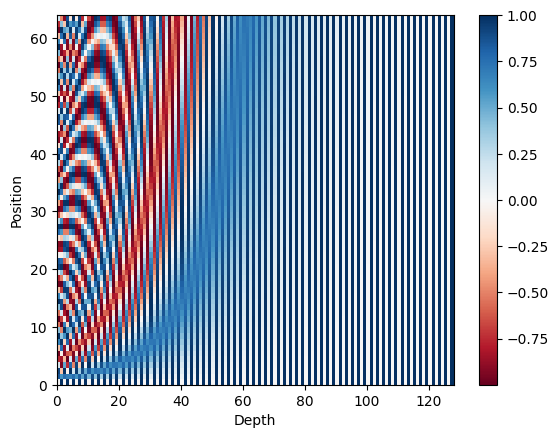

In [2]:
DIM = 128

class Embedding:
    def __init__(self):
        model_name = "bert-base-multilingual-cased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)

    def get_embedding(self, text):
        model_name = "bert-base-multilingual-cased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        inputs = tokenizer(text, return_tensors="pt")
        return inputs['input_ids'][0]
    
    def get_positional_encoding(self, embeddings):
        #pos=토큰 위치 / i? / dmodel = DIM = 64
        # pos 는 입력 문장에서의 임베딩 토큰의 위치를 나타내며, i는 임베딩 벡터 내의 차원의 인덱스
        # 𝑃𝐸(𝑝𝑜𝑠,2𝑖)=𝑠𝑖𝑛(𝑝𝑜𝑠/10000)2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙)
        # 𝑃𝐸(𝑝𝑜𝑠,2𝑖+1)=𝑐𝑜𝑠(𝑝𝑜𝑠/10000)2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙)
        pos_vectors = []
        for vector_idx, vector in enumerate(embeddings):
            pos_vector = []
            for token_idx, token in enumerate(vector):
                if token_idx % 2 == 0:
                    pos_value = math.sin(vector_idx/10000) ** 2*token_idx/DIM
                else:
                    pos_value = math.cos(vector_idx/10000) ** 2*token_idx/DIM
                pos_vector.append(pos_value)
            pos_vectors.append(pos_vector)
        return pos_vectors
    
    def get_positional_table(n_pos, n_dim):
    #pos=토큰 위치 / i? / dmodel = DIM = 64
    # pos 는 입력 문장에서의 임베딩 토큰의 위치를 나타내며, i는 임베딩 토큰 내의 차원 인덱스
    # 𝑃𝐸(𝑝𝑜𝑠,2𝑖)=𝑠𝑖𝑛(𝑝𝑜𝑠/10000)2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙)
    # 𝑃𝐸(𝑝𝑜𝑠,2𝑖+1)=𝑐𝑜𝑠(𝑝𝑜𝑠/10000)2𝑖/𝑑𝑚𝑜𝑑𝑒𝑙)
    pos_vectors = []
    for vector_idx in range(n_pos):
        pos_vector = []
        for token_idx in range(n_dim):
            if token_idx % 2 == 0:
                pos_value = math.sin(vector_idx/10000 ** (token_idx/DIM))
            else:
                pos_value = math.cos(vector_idx/10000 ** ((token_idx-1)/DIM))
            pos_vector.append(pos_value)
        pos_vectors.append(pos_vector)

    return pos_vectors

embedding = Embedding()
# text_list = ["안녕하세요. 반갑습니다. 정동호입니다.", "트랜스포머를 구현해보겠습니다."]
# input_ids = []
# for text in text_list:
#     input_ids.append(embedding.get_embedding(text))

# inputs = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
# sample_pos_encoding = embedding.get_positional_encoding(inputs)
sample_pos_encoding = embedding.get_positional_table(64, DIM)

plt.pcolormesh(sample_pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Encoder
- multi-head self attention layer
- Feed Forward layer
- Residual connection
- layer normalization

In [2]:
from torch import nn
import copy
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__() 
        # super().__init__()는 안되나?
        # 좀 더 명확하게 super를 사용하기 위해서는 단순히 super().__init__()을 하는 것이 아니라 super(파생클래스, self).__init__() 을 해준다.
        # 이와 같이 적어주면 기능적으로 차이는 없지만, 파생클래스와 self를 넣어서 현재 클래스가 어떤 클래스인지 명확하게 표시해줄 수 있다.
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, x):
        out = self.encoder(x)
        return out
    
    def decode(self, z, context):
        out = self.decoder(y, context)
        return out
    
    def forward(self, x, z):
        context = self.encode(x)
        result = self.decode(z, context)
        return result

In [3]:
class Encoder(nn.Module):
    def __init__(self, encoder_block, n_layer):
        super(Encoder, self).__init__()
        self.layers = [copy.deepcopy(encoder_block) for i in range(n_layer)]
    
    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return output
            
            
class EncoderBlock(nn.Module):
    def __init__(self, multi_head_att, feed_forward, res_conn, layer_norm):
        super(EncoderBlock, self).__init__()
        self.multi_head_att = multi_head_att
        self.feed_forward = feed_forward
        self.res_conn = res_conn
        self.layer_norm = layer_norm
        
    def forward(self, x):
        output = self.multi_head_att(x, x, x)
        
        output = self.res_conn(output)
        output = self.layer_norm(output)
        
        output = self.feed_forward(output)
        output = self.res_conn(output)
        output = self.layer_norm(output)
        return output
    
class Attention(nn.Module):
    def __init__(self, d_k):
        super(Attention, self).__init__()
        self.d_k = d_k
        
    def forward(self, q, k, v, mask):
        # q, k, v = (n, d_k)
        # mask = (n, n)
        att_score = torch.matmul(q, torch.transpose(k)) # n, n)
        att_score = output/torch.sqrt(self.d_k) # (n, n)
        if mask:
            att_val = att_score.masked_fill(mask==0, -1e9) 
        att_prob = torch.softmax(att_val, dim=-1) # (n, n)
        att_val = torch.matul(output, v) # (n, d_v)
        return att_val
    
class MultiHeadAttention(nn.Module):
    def __init__(self, att, num_head, d_model):
        super(MultiHeadAttention, self).__init__()
        self.n_att = n_att
        self.att_layers = [att for f in range(num_head)]
        self.q_fcs = [nn.Linear(d_model, d_model//num_head) for f in range(num_head)]
        self.k_fcs = [nn.Linear(d_model, d_model//num_head) for f in range(num_head)]
        self.v_fcs = [nn.Linear(d_model, d_model//num_head) for f in range(num_head)]
        self.out_fc = nn.Linear(d_model, d_model)
    
    def forward(self, query, key, value):
        att_vals = []
        for i in range(n_att):
            q = self.q_fcs[i](query)
            k = self.k_fcs[i](key)
            v = self.v_fcs[i](value)
            att_val = self.att_layers[i](q, k, v)
            att_vals.append(att_val)
        output = torch.cat(att_vals, dim=0) # (n, d_model)
        output = self.out_fc(output) # (d_model, d_model)
        return output

## FC Layer 개념이 왜 나오지?
## 정말 간단하게도, input으로 들어오는 token embedding vector를 fully connected layer에 넣어 세 vector를 생성해낸다. 
## 세 vector를 생성해내는 FC layer는 모두 다르기 때문에, 결국 self-attention에서는 Query, Key, Value를 구하기 위해 3개의 서로 다른 FC layer가 존재한다.
# 이 FC layer들은 모두 같은 input shape, output shape를 갖는다. input shape가 같은 이유는 당연하게도 모두 다 동일한 token embedding vector를 input으로 받기 때문이다.
# 한편, 세 FC layer의 output shape가 같다는 것을 통해 각각 별개의 FC layer로 구해진 Query, Key, Value가 구체적인 값은 다를지언정 같은 shape를 갖는 vector가 된다는 것을 알 수 있다.
## -> 입력 값을 query, key value로 바꿔주는 역할을 fc layer을 통해 진행

## multi-head의 concat 방법?
## Q, K, V로 각각의 Attention을 계산해 concatenate하는 방식은 별개의 Attention 연산을 총 h회 수행해야 한다는 점에서 매우 비효율적이다. 
## 따라서 실제로는 Q, K, V 자체를 n×d_k가 아닌, n×d_{model}로 생성해내서 한 번의 Self-Attention 계산으로 n×d_{model}의 output을 만들어내게 된다. 
## 때문에 Q, K, V를 생성해내기 위한 d_{embed}×d_k의 weight matrix를 갖는 FC layer를 3∗h개 운용할 필요 없이 d_{embed}×d_{model}의 weight matrix를
## 갖는 FC layer를 3개만 운용하면 된다.
## 다양한 Attention을 반영한다는 Multi-Head Attention의 심오한 개념은 실제 구현상으로는 단지 d_k의 크기를 d_{model}로 확장시키는 단순한 변경으로 끝난다는 점이다. 
## 때문에 사람에 따라서는 Multi-Head Attention을 다양한 Attention을 반영한다기 보다는 Q, K, V vector에는 담을 수 있는 정보의 양이 
## d_k의 dimension으로는 절대적으로 너무 작기 때문에 더 많은 정보를 담아내기 위해 Q, K, V vector의 dimension을 늘린 것으로 이해하기도 한다.
        

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self):
        super(FeedForwardNetwork, self).__init__()
        